# Energy Consumption Analysis and Prediction using LSTM :

In [1]:
import torch
import torch.nn as nn
import pandas as pd 
import numpy as np  
import seaborn as sns 
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings('ignore')

## Explore and Prepare :

In [2]:
data = pd.read_csv('energy_consumption_dataset.csv')
data.head()

,Date,Energy Consumption
0,2020-01-01,305.311409
1,2020-01-02,299.374329
2,2020-01-03,307.646359
3,2020-01-04,316.811967
4,2020-01-05,299.651923


In [3]:
data.shape

(1460, 2)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                1460 non-null   object 
 1   Energy Consumption  1460 non-null   float64
dtypes: float64(1), object(1)
memory usage: 22.9+ KB


In [5]:
data.describe()

,Energy Consumption
count,1460.000000
mean,350.451726
std,31.566215
min,265.886301
25%,324.913290
50%,349.962555
75%,375.550666
max,424.172656


In [6]:
data.isna().sum()

Date                  0
Energy Consumption    0
dtype: int64

In [7]:
data['Date'] = pd.to_datetime(data['Date'])

<Axes: xlabel='Energy Consumption', ylabel='Density'>

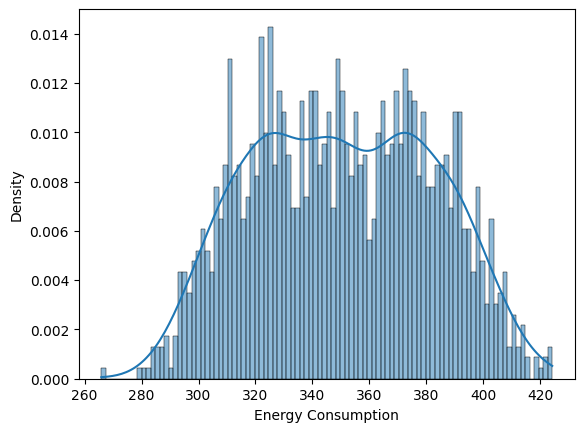

In [8]:
# data['Energy Consumption'].hist(bins=60)
sns.histplot(data['Energy Consumption'], bins=100, kde=True, stat="density")

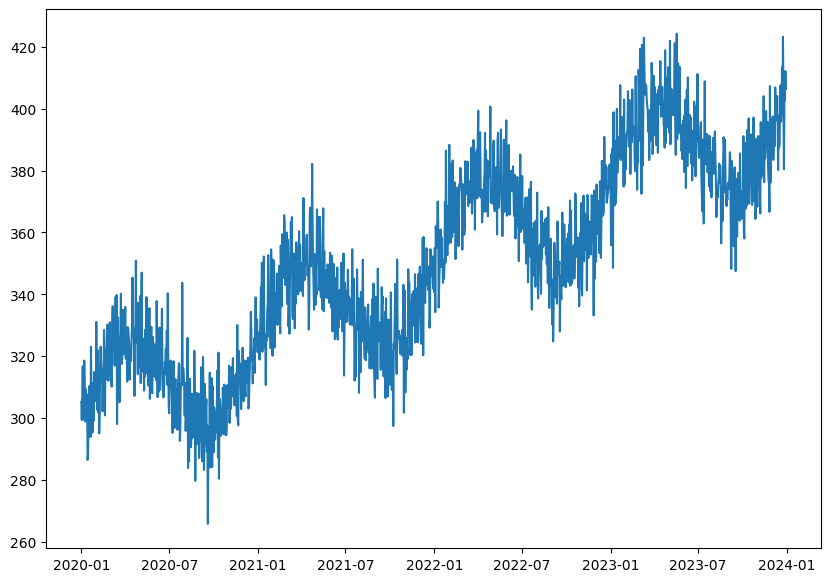

In [9]:
plt.figure(figsize=(10, 7))
plt.plot(data['Date'], data['Energy Consumption'])

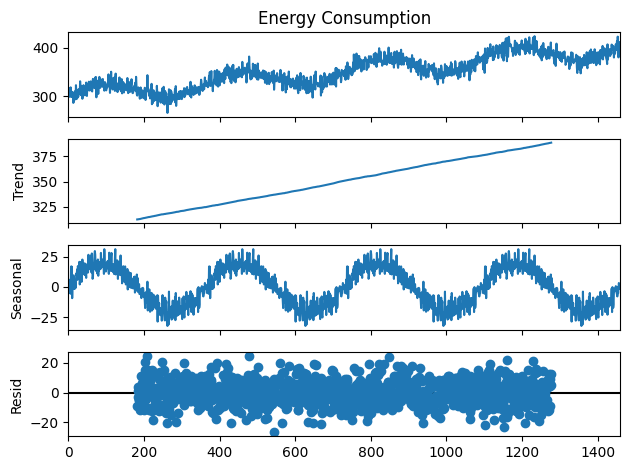

In [10]:
# Decompose the time series to see trend and seasonality
decomposition = seasonal_decompose(data['Energy Consumption'], model='additive', period=365)
decomposition.plot()
plt.show()

In [11]:
data_2020 = data[(data['Date'] >= '2020-01-01') & (data['Date'] < '2021-01-01')]
data_2021 = data[(data['Date'] >= '2021-01-01') & (data['Date'] < '2022-01-01')]
data_2022 = data[(data['Date'] >= '2022-01-01') & (data['Date'] < '2023-01-01')]
data_2023 = data[(data['Date'] >= '2023-01-01') & (data['Date'] < '2024-01-01')]

In [12]:
data_2020['Month_Day'] = data_2020['Date'].dt.strftime('%m-%d')
data_2021['Month_Day'] = data_2021['Date'].dt.strftime('%m-%d')
data_2022['Month_Day'] = data_2022['Date'].dt.strftime('%m-%d')
data_2023['Month_Day'] = data_2023['Date'].dt.strftime('%m-%d')

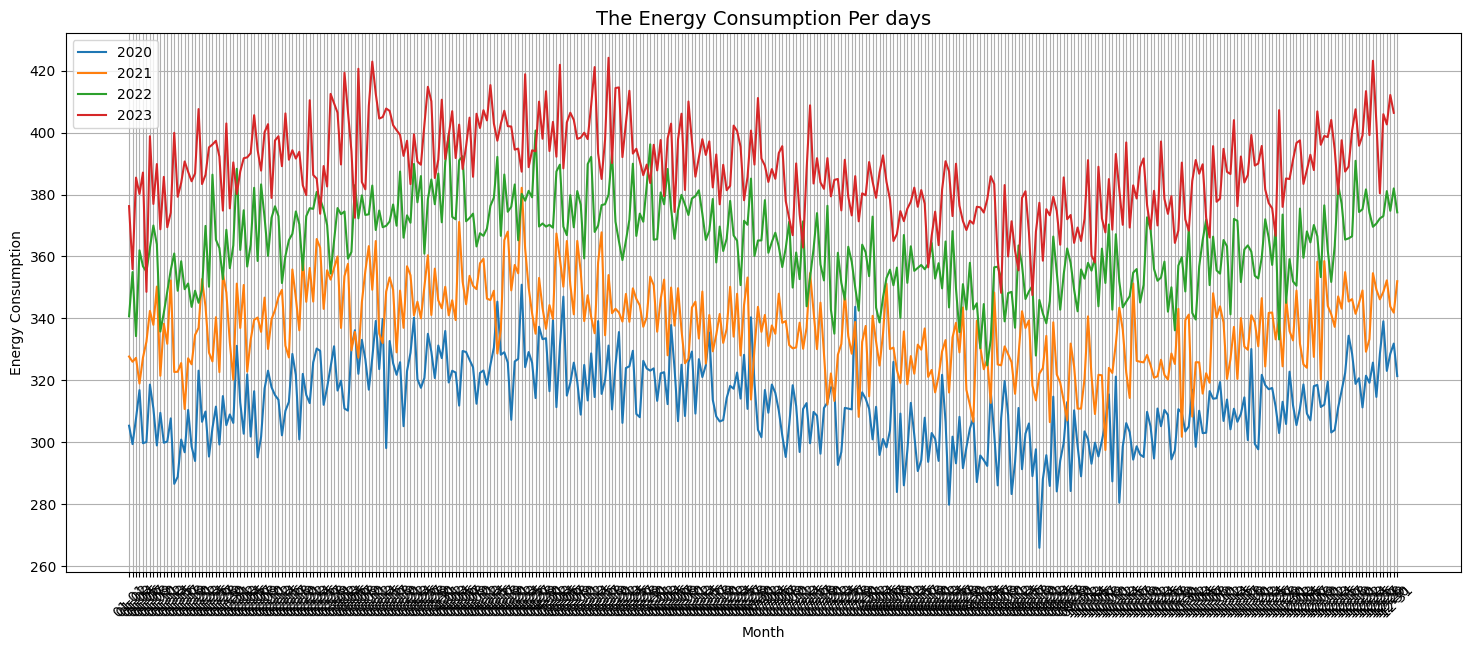

In [13]:
plt.figure(figsize=(18, 7))
plt.plot(data_2020['Month_Day'], data_2020['Energy Consumption'], label='2020')
plt.plot(data_2021['Month_Day'], data_2021['Energy Consumption'], label='2021')
plt.plot(data_2022['Month_Day'], data_2022['Energy Consumption'], label='2022')
plt.plot(data_2023['Month_Day'], data_2023['Energy Consumption'], label='2023')

plt.title('The Energy Consumption Per days', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

### Question 1: What does the seasonal pattern in this dataset represent and why is it important for energy consumption:

##### the seasonal pattern in this dataset indicates that energy consumption is similar for each year, which is important because it will make data analysis easier. That is why we will analyze energy consumption over a period of one year only.
=> I chose 2020 for the analysis

In [14]:
data_2020.head()

,Date,Energy Consumption,Month_Day
0,2020-01-01,305.311409,01-01
1,2020-01-02,299.374329,01-02
2,2020-01-03,307.646359,01-03
3,2020-01-04,316.811967,01-04
4,2020-01-05,299.651923,01-05


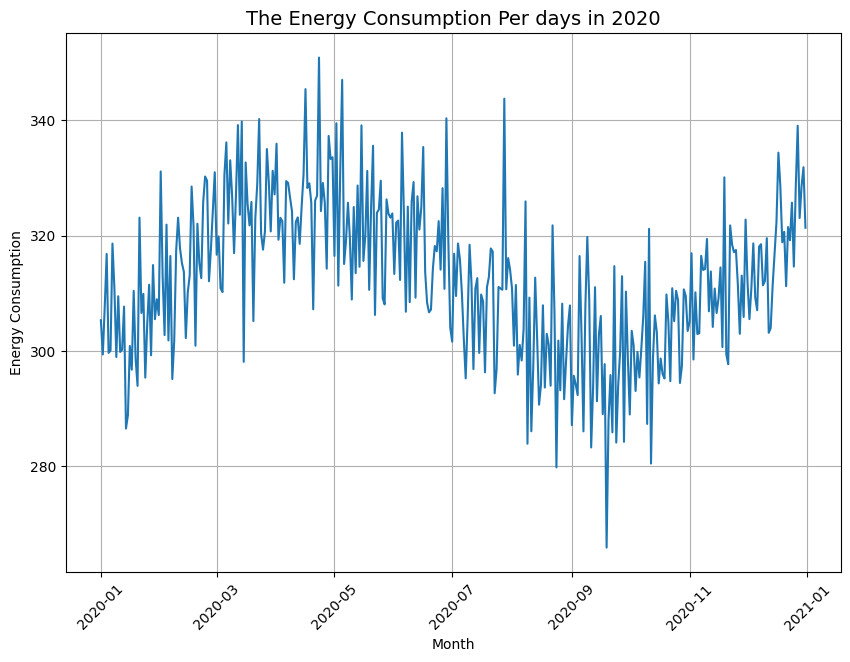

In [15]:
plt.figure(figsize=(10, 7))
plt.plot(data_2020['Date'], data_2020['Energy Consumption'])

plt.title('The Energy Consumption Per days in 2020', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [16]:
data_2020.describe()

,Date,Energy Consumption
count,366,366.000000
mean,2020-07-01 12:00:00,312.597738
min,2020-01-01 00:00:00,265.886301
25%,2020-04-01 06:00:00,303.066448
50%,2020-07-01 12:00:00,311.992582
75%,2020-09-30 18:00:00,322.362134
max,2020-12-31 00:00:00,350.863266
std,NaN,13.403631


In [17]:
data_2020['Month'] = data_2020['Date'].dt.to_period('M')
monthly_mean = data_2020.groupby('Month')['Energy Consumption'].mean()
monthly_mean

Month
2020-01    304.388147
2020-02    316.124356
2020-03    324.383183
2020-04    326.360898
2020-05    322.284891
2020-06    318.974214
2020-07    309.859024
2020-08    301.199301
2020-09    297.335097
2020-10    301.452450
2020-11    310.844051
2020-12    318.295521
Freq: M, Name: Energy Consumption, dtype: float64

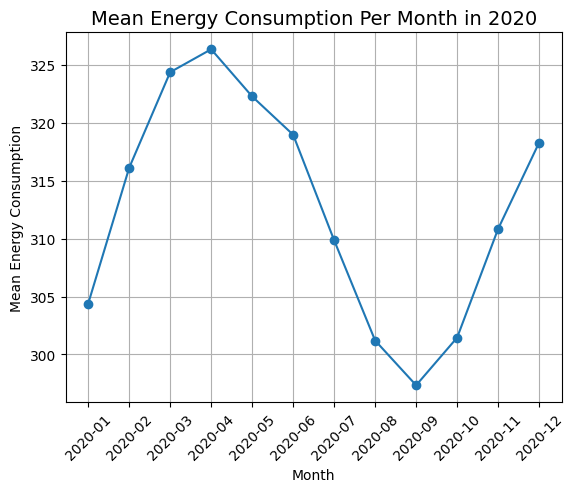

In [18]:
plt.plot(monthly_mean.index.astype(str), monthly_mean, marker='o')

plt.title('Mean Energy Consumption Per Month in 2020', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Mean Energy Consumption')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Question 2: What observations can you make from the average energy consumption per month? Which periods of the year consume more energy and why?

##### From the 2 figures, we can observe that:

- Highest consumption: April (4) has the highest energy consumption, probably due to increased demand during the winter transition.
- Lowest consumption: September (9) has the lowest energy consumption, often due to the mild temperatures of autumn.

**Explanation of variations**:
- In winter: heating of buildings
- In summer: air conditioning (but less intense than winter heating)
- Intermediate periods (spring and autumn) require less energy because the temperatures are milder

## Implementation
### prepare the data:

- Normalize the data.
- Create sequences adapted to the LSTM model.

In [19]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Normalized Energy Consumption'] = scaler.fit_transform(data[['Energy Consumption']])

In [20]:
data.head()

,Date,Energy Consumption,Normalized Energy Consumption
0,2020-01-01,305.311409,0.249075
1,2020-01-02,299.374329,0.211566
2,2020-01-03,307.646359,0.263826
3,2020-01-04,316.811967,0.321731
4,2020-01-05,299.651923,0.213320


In [41]:
# Prepare data for LSTM model
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# SEQ_LENGTH = 30  # Use past 30 days for prediction
SEQ_LENGTH = 15
X, y = create_sequences(data['Normalized Energy Consumption'].values, SEQ_LENGTH)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Reshape X_train and X_test to add the input_size dimension
X_train = X_train.unsqueeze(-1)
X_test = X_test.unsqueeze(-1)

print(len(X_train), len(X_test))

1156 289


In [22]:
X_train[0]

tensor([[0.7918],
        [0.8262],
        [0.8314],
        [0.7426],
        [0.7712],
        [0.8020],
        [0.7709],
        [0.8906],
        [0.8225],
        [0.8404],
        [0.8383],
        [0.8730],
        [0.8128],
        [0.7220],
        [0.8317]])

In [23]:
y_train[0]

tensor(0.7678)

## Implementation of the LSTM model :

In [24]:
# Define LSTM
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states with the correct batch size
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))  # LSTM layer
        out = self.fc(out[:, -1, :])      # Fully connected layer for prediction
        return out

In [25]:
# Instantiate the model, define loss function and optimizer
model = LSTM(input_size=1, hidden_size=50, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
model.train()

for epoch in range(num_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train.unsqueeze(1))  # Unsqueeze to match output shape
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.1293
Epoch [20/100], Loss: 0.0593
Epoch [30/100], Loss: 0.0374
Epoch [40/100], Loss: 0.0303
Epoch [50/100], Loss: 0.0279
Epoch [60/100], Loss: 0.0232
Epoch [70/100], Loss: 0.0150
Epoch [80/100], Loss: 0.0057
Epoch [90/100], Loss: 0.0063
Epoch [100/100], Loss: 0.0051


In [26]:
# Evaluation
def evaluate(model) :
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

    # Rescale predictions back to original scale
    y_test_rescaled = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
    y_pred_rescaled = scaler.inverse_transform(y_pred.numpy())

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R-squared (R2): {r2:.4f}')

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_rescaled, label='Actual')
    plt.plot(y_pred_rescaled, label='Predicted')
    plt.title('Actual vs Predicted Energy Consumption')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.show()

Mean Squared Error (MSE): 141.7112
Root Mean Squared Error (RMSE): 11.9043
R-squared (R2): 0.8626


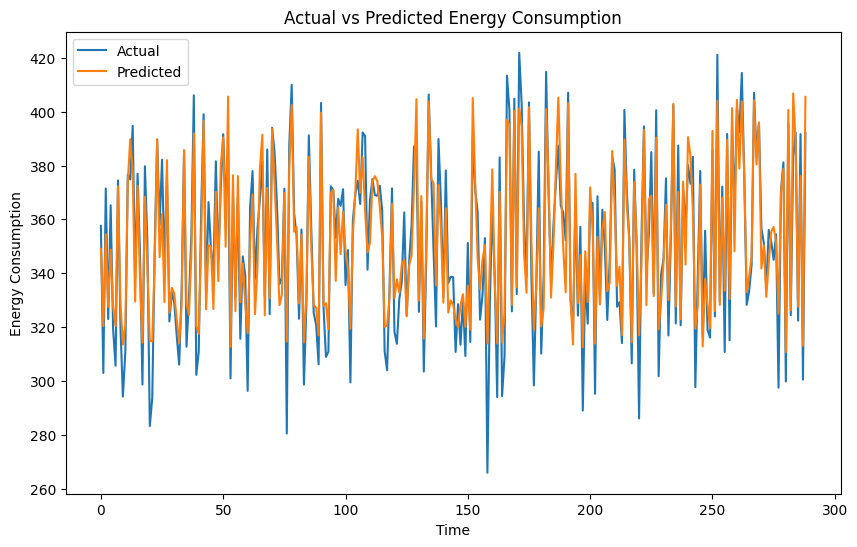

In [27]:
evaluate(model)

## Parameters and impact
#### Influence of the number of cells (3 configurations) / Metrics + visualization:

In [28]:
# definire une fonction global pour train et evaluate
def train_and_evaluate(hidden_size, num_cells=50, num_layers=2, seq_length=15, optimizer_choice='Adam'):
    print(f"\n--- Training with hidden_size = {hidden_size}, num_layers = {num_layers}, seq_length = {seq_length}, optimizer = {optimizer_choice} ---")
    
    model = LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1)
    criterion = nn.MSELoss()
    optimizer = getattr(torch.optim, optimizer_choice)(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(100):
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train.unsqueeze(1))
        loss.backward()
        optimizer.step()
    
    evaluate(model)



--- Training with hidden_size = 50, num_layers = 2, seq_length = 15, optimizer = Adam ---
Mean Squared Error (MSE): 147.0668
Root Mean Squared Error (RMSE): 12.1271
R-squared (R2): 0.8575


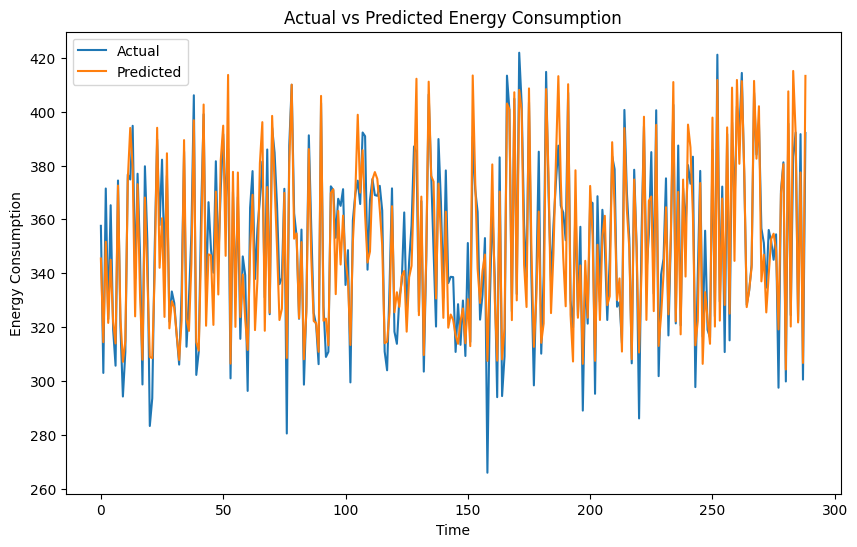


--- Training with hidden_size = 100, num_layers = 2, seq_length = 15, optimizer = Adam ---
Mean Squared Error (MSE): 126.7460
Root Mean Squared Error (RMSE): 11.2582
R-squared (R2): 0.8772


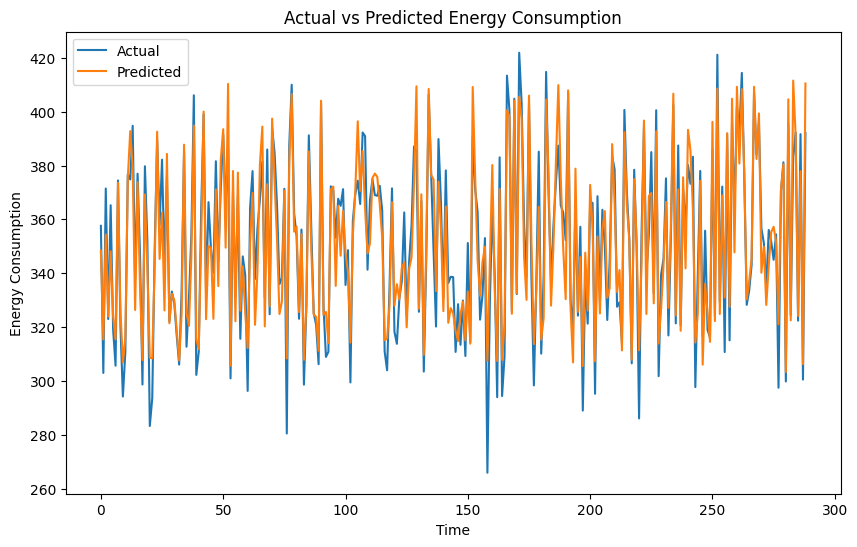


--- Training with hidden_size = 150, num_layers = 2, seq_length = 15, optimizer = Adam ---
Mean Squared Error (MSE): 118.8984
Root Mean Squared Error (RMSE): 10.9041
R-squared (R2): 0.8848


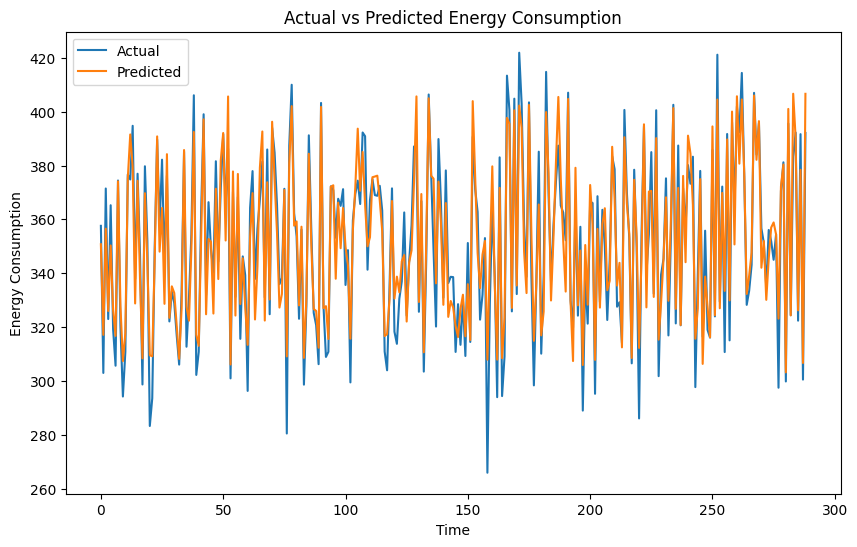

In [29]:
for hidden_size in [50, 100, 150]:
    train_and_evaluate(hidden_size)

=> The best results for the number of neurons are with **hidden_size = 150**, but all values ​​of **hidden_size** in [50, 100, 150] have good performance and they are very close.

#### Layer number influences (3 configurations) / Metric + visualization


--- Training with hidden_size = 50, num_layers = 1, seq_length = 15, optimizer = Adam ---
Mean Squared Error (MSE): 145.1202
Root Mean Squared Error (RMSE): 12.0466
R-squared (R2): 0.8593


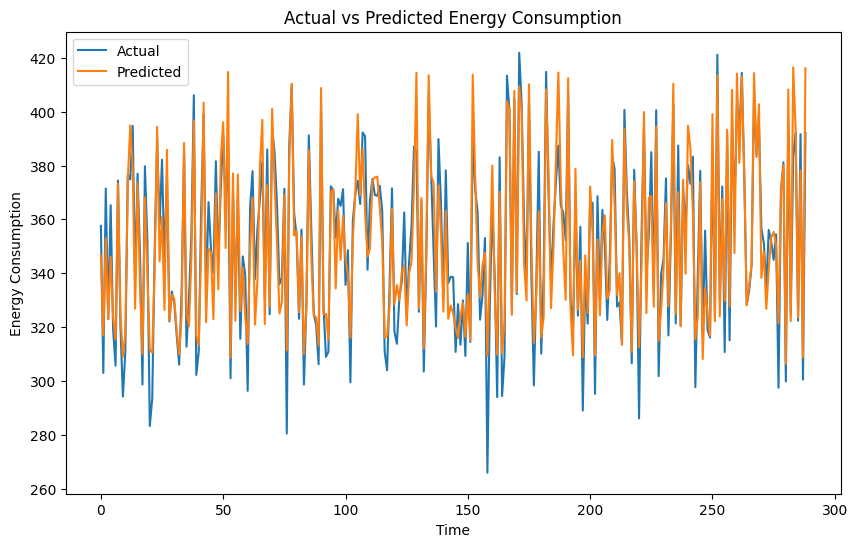


--- Training with hidden_size = 50, num_layers = 2, seq_length = 15, optimizer = Adam ---
Mean Squared Error (MSE): 148.9048
Root Mean Squared Error (RMSE): 12.2027
R-squared (R2): 0.8557


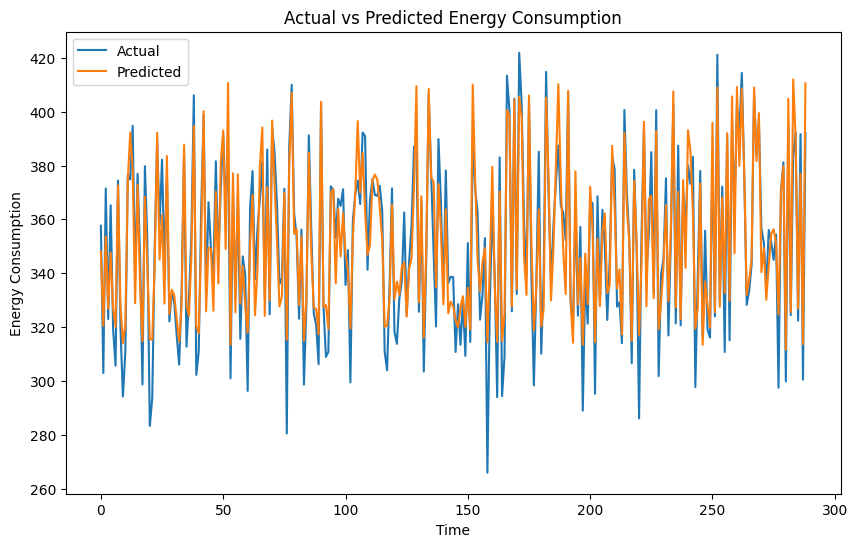


--- Training with hidden_size = 50, num_layers = 3, seq_length = 15, optimizer = Adam ---
Mean Squared Error (MSE): 126.2935
Root Mean Squared Error (RMSE): 11.2380
R-squared (R2): 0.8776


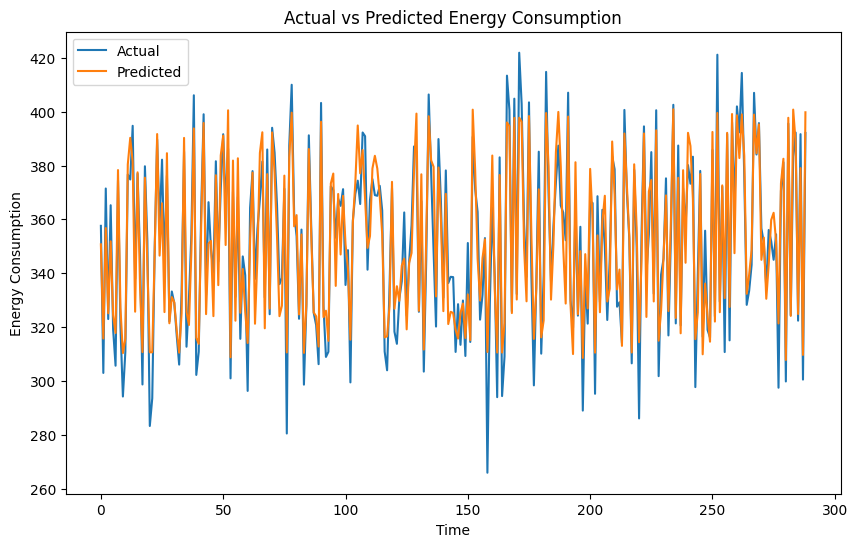

In [42]:
# Test three configurations for number of layers
for num_layers in [1, 2, 3]:
    train_and_evaluate(hidden_size=50, num_layers=num_layers)

=> The best results for the number of layers are with **num_layers = 3**, but all values ​​of **num_layers** in [1, 2, 3] have good performance and they are very close.

#### Influence of the age of the training data (3 configurations) / metrics


--- Training with hidden_size = 50, num_layers = 2, seq_length = 10, optimizer = Adam ---
Mean Squared Error (MSE): 111.9739
Root Mean Squared Error (RMSE): 10.5818
R-squared (R2): 0.8718


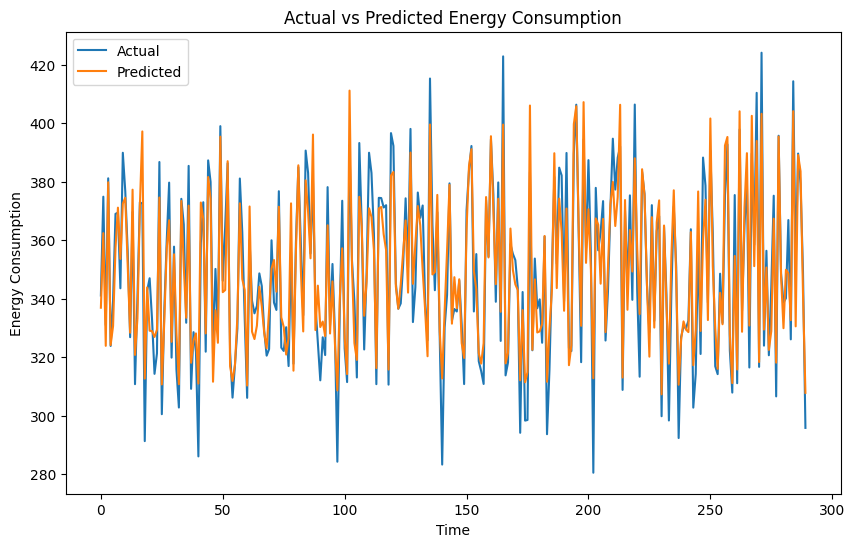


--- Training with hidden_size = 50, num_layers = 2, seq_length = 15, optimizer = Adam ---
Mean Squared Error (MSE): 150.0315
Root Mean Squared Error (RMSE): 12.2487
R-squared (R2): 0.8546


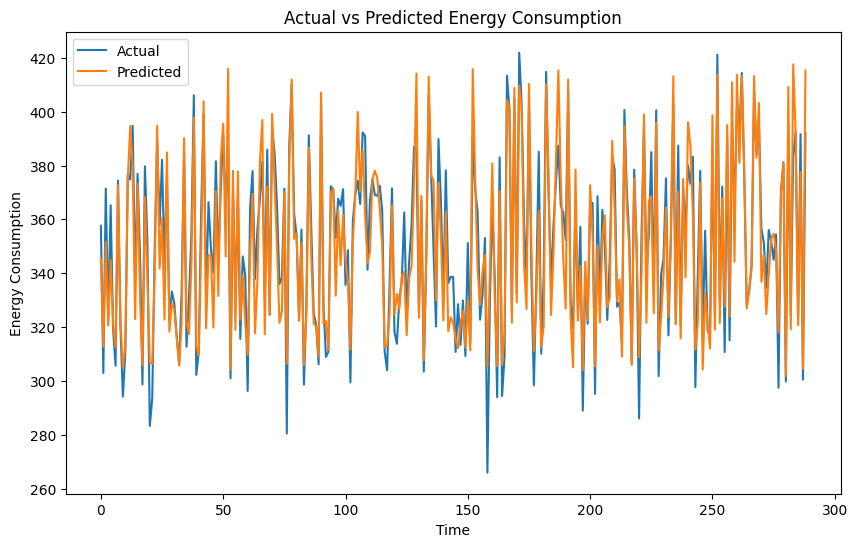


--- Training with hidden_size = 50, num_layers = 2, seq_length = 30, optimizer = Adam ---
Mean Squared Error (MSE): 135.7033
Root Mean Squared Error (RMSE): 11.6492
R-squared (R2): 0.8720


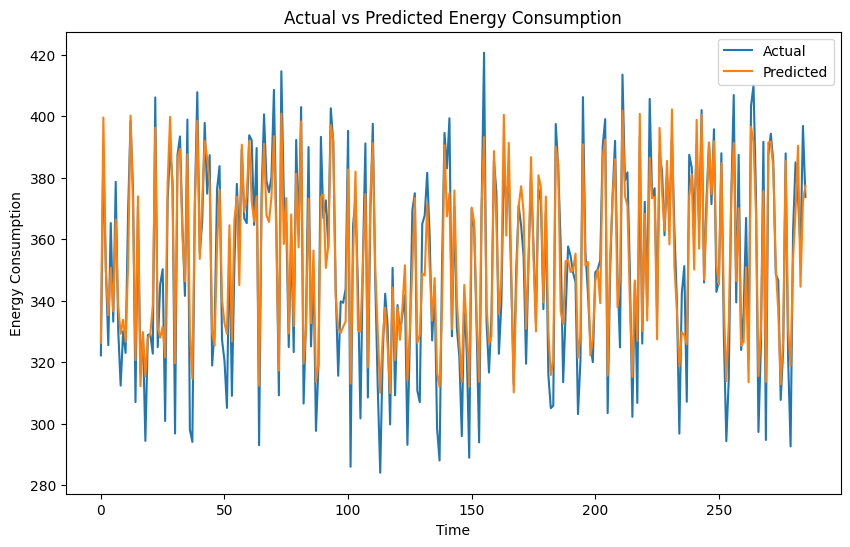

In [37]:
# Test three configurations for sequence length
for seq_length in [10, 15, 30]:
    X, y = create_sequences(data['Normalized Energy Consumption'].values, seq_length)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    
    # Reshape X_train and X_test to add the input_size dimension
    X_train = X_train.unsqueeze(-1)
    X_test = X_test.unsqueeze(-1)
    
    # train and evaluate
    train_and_evaluate(hidden_size=50, seq_length=seq_length)

Analysis:
- Lower MSE and RMSE: The first model (seq_length = 10) has a lower MSE and RMSE, indicating a slightly better accuracy in terms of error.
- Higher R²: The second model (seq_length = 15) has a slightly higher R², suggesting a better fit to the data in terms of explained variance.

Conclusion:

The first model (seq_length = 10) is slightly better overall, as it has lower MSE and RMSE values, implying that it has lower prediction errors. The difference in R² between the two models is small and does not compensate for the difference in error.

#### Optimizer influence (3 configurations and metrics)


--- Training with hidden_size = 50, num_layers = 2, seq_length = 15, optimizer = Adam ---
Mean Squared Error (MSE): 140.5039
Root Mean Squared Error (RMSE): 11.8534
R-squared (R2): 0.8638


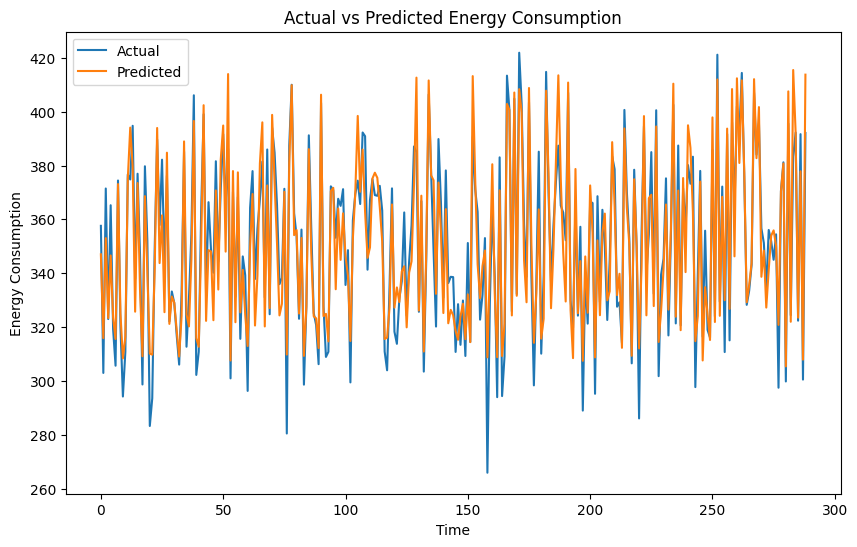


--- Training with hidden_size = 50, num_layers = 2, seq_length = 15, optimizer = SGD ---
Mean Squared Error (MSE): 7997.8564
Root Mean Squared Error (RMSE): 89.4307
R-squared (R2): -6.7519


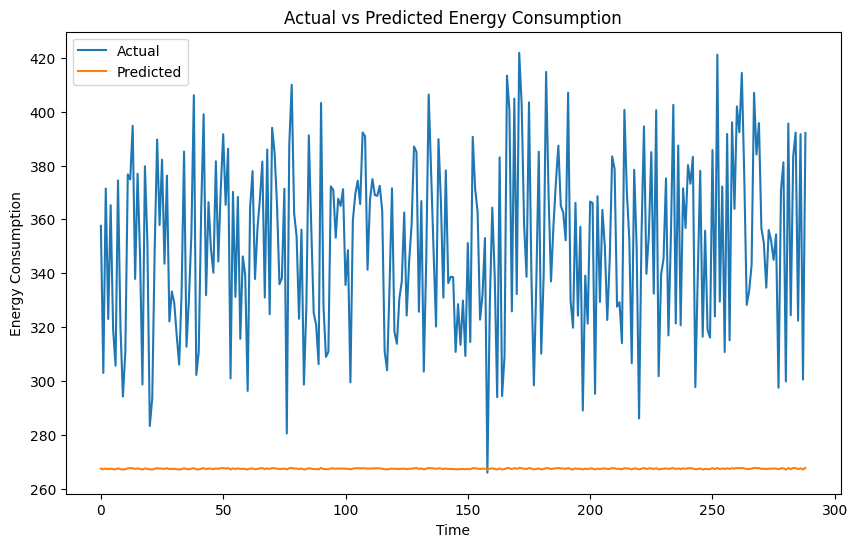


--- Training with hidden_size = 50, num_layers = 2, seq_length = 15, optimizer = RMSprop ---
Mean Squared Error (MSE): 214.5393
Root Mean Squared Error (RMSE): 14.6472
R-squared (R2): 0.7921


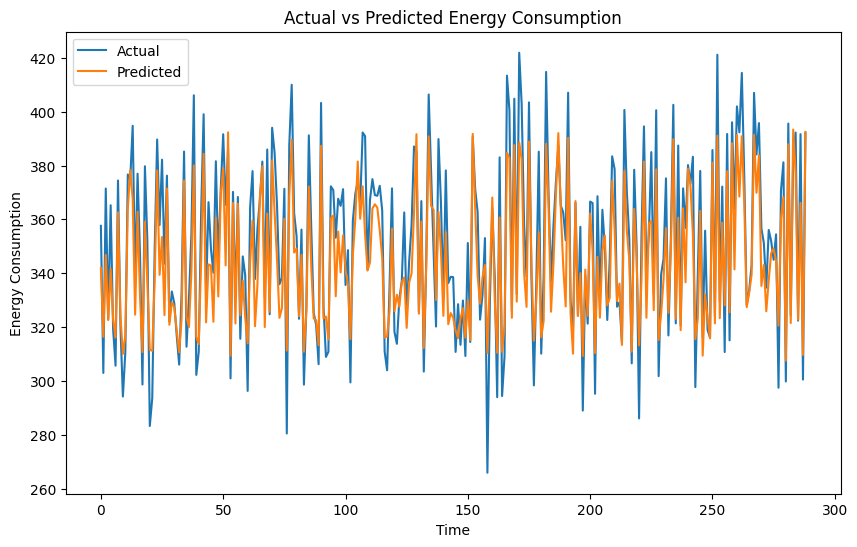

In [40]:
# Test three configurations for optimizer choice
for optimizer_choice in ['Adam', 'SGD', 'RMSprop']:
    train_and_evaluate(hidden_size=50, optimizer_choice=optimizer_choice)

=> The best results for the optimizer are with **optimizer = Adam (Adaptive Moment Estimation)**, it is close for **RMSprop (Root Mean Square Propagation)**, and the optimizer **SGD (Stochastic Gradient Descent)** has the worst result.

---
### Final Implementation:


--- Training with hidden_size = 150, num_layers = 3, seq_length = 15, optimizer = Adam ---
Mean Squared Error (MSE): 103.4072
Root Mean Squared Error (RMSE): 10.1689
R-squared (R2): 0.9024


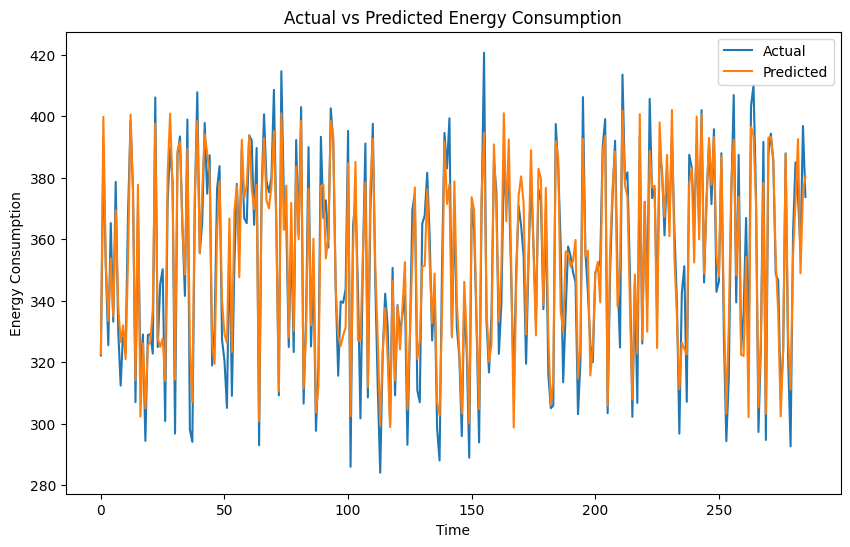

In [33]:
train_and_evaluate(hidden_size=150, num_layers=3, seq_length = 15, optimizer_choice='Adam')

## Comparison the LSTM agains BI-LSTM :

In [34]:
class BiLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True  # Enable bi-directional LSTM

        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, bidirectional=self.bidirectional)
        
        # Fully connected layer to produce the output
        # Hidden size is doubled due to bi-directional (hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        # Initialize hidden and cell states with the correct batch size
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate through the Bi-LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Fully connected layer for the final output
        out = self.fc(out[:, -1, :])  # Use only the last output for prediction
        return out

Epoch [20/150], Loss: 0.0312
Epoch [40/150], Loss: 0.0208
Epoch [60/150], Loss: 0.0050
Epoch [80/150], Loss: 0.0045
Epoch [100/150], Loss: 0.0044
Epoch [120/150], Loss: 0.0044
Epoch [140/150], Loss: 0.0044
Mean Squared Error (MSE): 103.2611
Root Mean Squared Error (RMSE): 10.1617
R-squared (R2): 0.9026


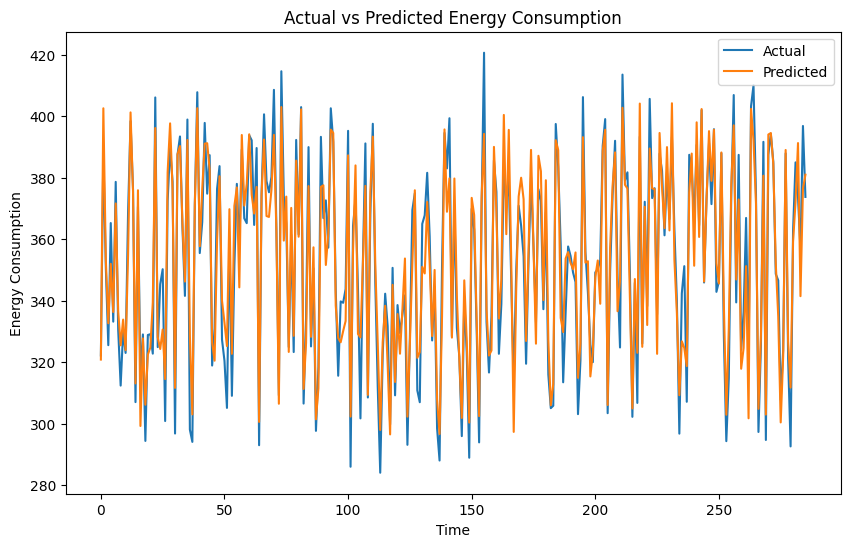

In [35]:
# Instantiate the model, define loss function and optimizer
model = BiLSTM(input_size=1, hidden_size=150, num_layers=3, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 150
model.train()

for epoch in range(num_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train.unsqueeze(1))  # Unsqueeze to match output shape
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
evaluate(model)

### The Performance of BiLSTM is very close to LSTM.